**Seqeval** is a Python framework for evaluation of sequence labeling. seqeval can evaluate the performance of chunking tasks like named entity recognition, part-of-speech tagging, semantic role labeling and so on.

In [ ]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=d94ac9a7222424da793681930ff3b0555eec0407bd16097ba0fa8e37b68f1b9a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Install transformers module for NER process needs using BERT transformer
!pip install transformers

     |████████████████████████████████| 2.6 MB 6.8 MB/s 
     |████████████████████████████████| 895 kB 55.9 MB/s 
     |████████████████████████████████| 3.3 MB 52.6 MB/s 
     |████████████████████████████████| 636 kB 74.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# **IMPORT NEEDED MODULE**

Modules for model evaluation purposes:
* from seqeval.metrics import f1_score
* from seqeval.metrics import classification_report accuracy_score,f1_score

Modules/libraries for deep learning/transfer learning models:
* import torch.nn.functional as F
* import torch
* from torch.optim import Adam 
* from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
* from keras.preprocessing.sequence import pad_sequences
* from transformers import BertTokenizer, BertConfig
* from transformers import BertForTokenClassification, AdamW
* from transformers import get_linear_schedule_with_warmup

Module for dataset sharing:
* from sklearn.model_selection import train_test_split

Module to display progress bar:
* from tqdm import tqdm,trange

Module for graphic visualization purposes:
* import matplotlib.pyplot as plt
* import seaborn as sns

Module for time calculation purposes:
* import time
* import datetime

Modules for data manipulation purposes:
* import pandas as pd
* import math
* import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import datetime
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
header_names = ['Word', 'Tag']
df1 = pd.read_csv("train_corrected.txt",sep='\t', names=header_names)
df1

In [ ]:
header_names = ['Word', 'Tag']
df2 = pd.read_csv("test_corrected.txt", sep='\t', quoting=3, names=header_names)
df2

In [ ]:
header_names = ['Word', 'Tag']
df3 = pd.read_csv("valid_corrected.txt",sep='\t', names=header_names)
df3

In [ ]:
data = pd.concat([df1, df2, df3], axis=0)
data

In [ ]:
data.to_csv('ner_dataset_id.txt', sep='\t', mode='a', index=None, header=None)

In [ ]:
# Create a filename variable that holds the dataset ner
filename = 'ner_dataset_id.txt'

In [ ]:
# Make a sentence id based on the sentence not based on the word
def get_ner_data(filename):
    word_list = []
    sentence_counter = 0
    with open(filename) as fp:
        for cnt, line in enumerate(fp):
            try:
                texts = line.split()
                if len(texts) != 0:
                    word, label = ' '.join(texts[0:-1]), texts[-1]
                    word_list.append([sentence_counter, word, label])
                else:
                    sentence_counter += 1
            except:
                print("Unexpected error:", sys.exc_info()[0], cnt, line)
                word_list.append([sentence_counter, "", ""])              
                sentence_counter += 1
                pass
    print(f'read {cnt} lines')
    ner_data = pd.DataFrame(word_list, columns=["sentence_id", "words", "labels"])
    return ner_data

In [ ]:
# Execute the get_ner_data function on the ner dataset
df_data = get_ner_data(filename)

read 452937 lines


In [ ]:
# Display the result of the function get_ner_data
df_data.head(10)

,sentence_id,words,labels
0,0,mengekspor,O
1,0,produk,O
2,0,industri,O
3,0,skala,O
4,0,besar,O
5,0,ke,O
6,0,Indonesia,B-GPE
7,0,Amerika,B-GPE
8,0,Serikat,I-GPE
9,0,.,O


In [ ]:
# Count the amount of data in the value column labels
df_data.labels.value_counts()

O        303627
I-DAT     13656
B-PER      9524
B-GPE      9087
I-NOR      8201
I-ORG      7063
I-PER      6357
B-PRD      5807
I-PRD      5744
B-NOR      5638
B-CRD      5609
B-ORG      5583
I-LOC      5569
B-DAT      5156
I-MON      4236
B-LOC      3486
I-QTY      3266
I-GPE      3225
I-TIM      3048
I-EVT      2937
I-PRC      2248
I-CRD      2228
B-QTY      2078
I-LAW      1958
B-EVT      1779
B-MON      1719
I-FAC      1222
B-PRC      1131
B-TIM      1059
B-ORD       815
B-FAC       622
B-REG       453
B-LAW       431
I-WOA       386
I-REG       226
B-WOA       208
I-ORD        52
B-LAN        13
I-LAN        12
Name: labels, dtype: int64

In [ ]:
# Retrieve sentences with their labels.
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["words"].values.tolist(),
                                                     s["labels"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
# Displays an example sentence on the first data
getter = SentenceGetter(df_data)
sentences = [[s[0] for s in sent] for sent in getter.sentences]
print(sentences[0])

['mengekspor', 'produk', 'industri', 'skala', 'besar', 'ke', 'Indonesia', 'Amerika', 'Serikat', '.', 'Ekspor', 'dilakukan', 'melalui', 'Pelabuhan', 'Tanjung', 'Priok', ',', 'Jakarta', 'Utara', ',', 'Selasa', '(', '15', '/', '8', '/', '2018', ')', '.', 'Komoditas', 'yang', 'dikirim', 'terdiri', 'dari', '50', 'persen', 'sepatu', ',', '15', 'persen', 'garmen', ',', '10', 'persen', 'produk', 'karet', ',', 'ban', 'dan', 'turunannya', ',', 'alat', '-', 'alat', 'elektronik', '10', 'persen', ',', 'dan', 'produk', 'lainnya', '15', 'persen', '.', '"', 'Bukan', 'bahan', 'mentah', ',', 'tetapi', 'sudah', 'bahan', '-', 'bahan', 'produksi', ',', 'produk', '-', 'produk', 'industri', 'yang', 'kita', 'harapkan', 'ini', 'akan', 'meningkatkan', 'ekspor', 'kita', ',', '"', 'kata', 'Presiden', 'dalam', 'sambutannya', 'pada', 'acara', 'pelepasan', 'ekspor', 'di', 'Jakarta', 'International', 'Container', 'Terminal', '(', 'JICT', ')', ',', 'Selasa', '(', '15', '/', '5', '/', '2018', ')', '.', 'Ekspor', 'terse

In [ ]:
# Displays an example of a Tag label on the first data
labels = [[s[1] for s in sent] for sent in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'B-GPE', 'I-GPE', 'O', 'O', 'O', 'O', 'B-FAC', 'I-FAC', 'I-FAC', 'O', 'B-GPE', 'I-GPE', 'O', 'B-DAT', 'O', 'I-DAT', 'O', 'I-DAT', 'O', 'I-DAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PRC', 'I-PRC', 'B-PRD', 'O', 'B-PRC', 'I-PRC', 'B-PRD', 'O', 'B-PRC', 'I-PRC', 'O', 'B-PRD', 'O', 'B-PRD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PRC', 'I-PRC', 'O', 'O', 'O', 'O', 'B-PRC', 'I-PRC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'O', 'B-DAT', 'O', 'I-DAT', 'O', 'I-DAT', 'O', 'I-DAT', 'O', 'O', 'O', 'O', 'O', 'B-PRD', 'I-PRD', 'I-PRD', 'I-PRD', 'I-PRD', 'O', 'O', 'O', 'O', 'B-PRD', 'O', 'O', 'B-QTY', 'I-QTY', 'I-QTY', 'O', 'O', 'B-QTY', 'I-QTY', 'O', 'B-QTY', 'I-QTY', 'O', 'O', 'B-PRD', 'O', 'O', 'O', 'B-PRD', 'O', 'I-PRD', 'I-PRD', 'O', 'B-PRD', 'O', 'O', 'O', 'O', 'O

In [ ]:
# Create a variable tags_vals = a variable that holds the labels column data in the form of a list
tags_vals = list(set(df_data["labels"].values))

In [ ]:
# Add the letter X to the tags_vals variable, then add an index to each label
tags_vals.append('X')
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [ ]:
tags_vals

['O',
 'I-NOR',
 'B-ORD',
 'B-PER',
 'B-NOR',
 'B-REG',
 'B-LAN',
 'I-LAW',
 'I-DAT',
 'I-PRD',
 'I-GPE',
 'I-LAN',
 'I-WOA',
 'I-MON',
 'B-ORG',
 'B-PRD',
 'B-EVT',
 'B-PRC',
 'I-ORG',
 'I-EVT',
 'I-PRC',
 'B-LOC',
 'B-QTY',
 'I-ORD',
 'B-TIM',
 'I-FAC',
 'I-QTY',
 'B-GPE',
 'B-FAC',
 'B-CRD',
 'B-WOA',
 'B-LAW',
 'I-PER',
 'I-LOC',
 'I-CRD',
 'B-DAT',
 'I-REG',
 'B-MON',
 'I-TIM',
 'X']

In [ ]:
# View index results on tag data
tag2idx

{'B-CRD': 29,
 'B-DAT': 35,
 'B-EVT': 16,
 'B-FAC': 28,
 'B-GPE': 27,
 'B-LAN': 6,
 'B-LAW': 31,
 'B-LOC': 21,
 'B-MON': 37,
 'B-NOR': 4,
 'B-ORD': 2,
 'B-ORG': 14,
 'B-PER': 3,
 'B-PRC': 17,
 'B-PRD': 15,
 'B-QTY': 22,
 'B-REG': 5,
 'B-TIM': 24,
 'B-WOA': 30,
 'I-CRD': 34,
 'I-DAT': 8,
 'I-EVT': 19,
 'I-FAC': 25,
 'I-GPE': 10,
 'I-LAN': 11,
 'I-LAW': 7,
 'I-LOC': 33,
 'I-MON': 13,
 'I-NOR': 1,
 'I-ORD': 23,
 'I-ORG': 18,
 'I-PER': 32,
 'I-PRC': 20,
 'I-PRD': 9,
 'I-QTY': 26,
 'I-REG': 36,
 'I-TIM': 38,
 'I-WOA': 12,
 'O': 0,
 'X': 39}

In [ ]:
# Mapping index to name
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
n_gpu

1

In [ ]:
# Len sentences must be the same as the training model
# See 'max_position_embeddings' = 512
max_len  = 45

# load tokenizer, with manual file address or pretrained address
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize words and count the number of subwords broken into words
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add tokenized word to tokenized last word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the list of new labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]

labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
# Make text token id
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")
print(input_ids[0])

[27955  5937 13102  2953  4013 28351 27746 18886 24053  2721  2022 10286
 17710  6239  2572 27350  2050 14262  7556  2102  1012 23969 13102  2953
 29454  4817 15750  2078 11463  2389 10179 21877 20470 27225  2319  9092
 19792  2290 26927  6559  1010 14426 28981  2527  1010]


In [ ]:
# Make label to be id, pad with "O" which means other
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=max_len, value=tag2idx["X"], padding="post",
                     dtype="long", truncating="post")
print(tags[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0 27 27 27 27 10 10 10  0  0  0  0
  0  0  0  0  0  0  0 28 28 28 28 25 25 25 25 25  0 27 10 10  0]


In [ ]:
# For prediction accuracy, with token mask is 1, token pad is 0
attention_masks = [[int(i>0) for i in ii] for ii in input_ids]
attention_masks[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
# Because it is only one sentence, all segments are set to 0
segment_ids = [[0] * len(input_id) for input_id in input_ids]
segment_ids[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
# Divide the dataset into train and val
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(input_ids, tags,attention_masks,segment_ids, 
                                                                                                  random_state=4, test_size=0.2)

In [ ]:
# Create a dataset that has been divided into train and val data into tensor form
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)

In [ ]:
# Set batch_num size
batch_num = 32

In [ ]:
# Set only token embed, attention pinned, no segment embed
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last dapat membuat pelatihan batch lebih baik untuk yang terakhir
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

In [ ]:
# Run the BertForTokenClassification model using a pretrained bert-base-uncased, with a number of num labels based on the number of tag ids
model = BertForTokenClassification.from_pretrained("bert-base-uncased",num_labels=len(tag2idx))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
# Running model using cuda model
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# Get all model parameters in a list of tuples
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Add multi GPU support
if n_gpu >1:
    model = torch.nn.DataParallel(model)

In [ ]:
# True: fine-tune all layers
# False: only enhances the classifier layer
FULL_FINETUNING = True

In [ ]:
if FULL_FINETUNING:
    # Fine-tune the model of all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

In [ ]:
# Set epoch and grad max num
epochs = 5
max_grad_norm = 1.0

# The total number of training steps is the number of batches * the number of epochs.
total_steps = len(train_dataloader) * epochs

# Create a learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Save the loss value and validation loss value for each epoch so you can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the exercise set.

    # Put the model into training mode.
    model.train()
    # Reset total loss.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # Add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear pre-calculated gradients before performing backwards passes.
        model.zero_grad()
        # Forward feed   
        # This will return loss (not model output)
        # Because it has provided `label`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Perform a backward motion to calculate the gradient.
        loss.backward()
        # Track the value of train loss
        total_loss += loss.item()       
        # Gradient norm clip
        # This is to help prevent "gradient explosion" issues.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameter
        optimizer.step()
        # Update learning rate.
        scheduler.step()

    
    # Calculate the average loss of training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Save the result of the loss training value obtained
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After completing each training period, measure the performance of the validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset validation loss
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Tells the model not to calculate or save gradients,
        # save memory and speed up validation
        with torch.no_grad():
            # Forward pass, calculate logit prediction.
            # This will return a log instead of a loss because it has not provided a label.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        
        # Move logs and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
   
    print()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss: 0.8618221553577774


Epoch:  20%|██        | 1/5 [02:05<08:22, 125.67s/it]

Validation loss: 0.4769434576187659

Average train loss: 0.4008863110651915


Epoch:  40%|████      | 2/5 [04:18<06:23, 127.71s/it]

Validation loss: 0.34113697160821443

Average train loss: 0.2732286398609479


Epoch:  60%|██████    | 3/5 [06:31<04:18, 129.49s/it]

Validation loss: 0.2959327167327251

Average train loss: 0.20920894855055316


Epoch:  80%|████████  | 4/5 [08:45<02:10, 130.76s/it]

Validation loss: 0.2889885064385353

Average train loss: 0.173656714407877


Epoch: 100%|██████████| 5/5 [10:59<00:00, 131.84s/it]

Validation loss: 0.2834860639424499



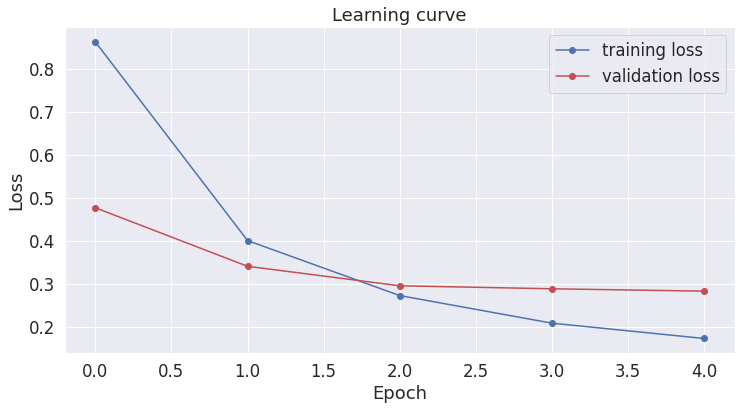

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
# Create a variable that will hold the model results and save it in a folder
bert_out_address = 'models/bert_out_model/id'
# Create self if not exit
if not os.path.exists(bert_out_address):
        os.makedirs(bert_out_address)

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model 

In [ ]:
# If we save using a predefined name, we can load using `from_pretrained`
output_model_file = os.path.join(bert_out_address, "pytorch_model.bin")
output_config_file = os.path.join(bert_out_address, "config.json")

# Save model into file
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(bert_out_address)

('models/bert_out_model/id/vocab.txt',)

In [ ]:
# Rerun the model but use pretrained from the previously saved training model
model = BertForTokenClassification.from_pretrained(bert_out_address,num_labels=len(tag2idx))

model.cuda(); # Set model ke GPU

if n_gpu >1:
    model = torch.nn.DataParallel(model)

In [ ]:
# Evaluate the model
model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))

y_true = []
y_pred = []

for batch in (valid_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
      attention_mask=b_input_mask,labels=b_labels)
      
      # For evaluation mode, the first result of the output is logits
      logits = outputs[1] 
  
  # Get NER prediction results
  logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
  logits = logits.detach().cpu().numpy()
  
  
  # Get real NER results
  label_ids = b_labels.to('cpu').numpy()
  
  # Only predict the actual word, mark = 0, will not count
  input_mask = b_input_mask.to('cpu').numpy()
  
  # Compare valuable prediction results
  for i,mask in enumerate(input_mask):
      # temp_1 for actual data
      temp_1 = []
      # temp_2 for prediction result data
      temp_2 = []
      
      for j, m in enumerate(mask):
          # Mark = 0, it means it's pad word, don't compare
          if m:
              if tag2name[label_ids[i][j]] != "X": # Exclude label X
                  temp_1.append(tag2name[label_ids[i][j]])
                  temp_2.append(tag2name[logits[i][j]])
          else:
              break
      
          
      y_true.append(temp_1)
      y_pred.append(temp_2)


print("f1 socre: %f"%(f1_score(y_true, y_pred)))
print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))

# Get acc, recall, report F1 results
report = classification_report(y_true, y_pred,digits=4)

# Save report into file
output_eval_file = os.path.join(bert_out_address, "eval_results.txt")
with open(output_eval_file, "w") as writer:
  print("***** Eval results *****")
  print("\n%s"%(report))
  print("f1 socre: %f"%(f1_score(y_true, y_pred)))
  print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))
  
  writer.write("f1 socre:\n")
  writer.write(str(f1_score(y_true, y_pred)))
  writer.write("\n\nAccuracy score:\n")
  writer.write(str(accuracy_score(y_true, y_pred)))
  writer.write("\n\n")  
  writer.write(report)

***** Running evaluation *****
  Num examples =3486
  Batch size = 32
f1 socre: 0.748082
Accuracy score: 0.926134
***** Eval results *****

              precision    recall  f1-score   support

         CRD     0.7859    0.8711    0.8263      1218
         DAT     0.9155    0.9357    0.9255      1088
         EVT     0.6259    0.6121    0.6189       593
         FAC     0.5060    0.3853    0.4375       218
         GPE     0.8171    0.8624    0.8392      2777
         LAN     0.0000    0.0000    0.0000         8
         LAW     0.4125    0.2426    0.3056       136
         LOC     0.5059    0.5537    0.5287      1015
         MON     0.9206    0.9627    0.9412       482
         NOR     0.7228    0.8085    0.7633      2235
         ORD     0.7702    0.7490    0.7594       255
         ORG     0.6409    0.6471    0.6440      1961
         PER     0.8534    0.8626    0.8580      2903
         PRC     0.9485    0.8897    0.9181       145
         PRD     0.5645    0.5745    0.5695      

In [ ]:
test_sentence = """
Berdasarkan data Badan Penelitian dan Pengembangan Kesehatan (Balitbangkes) ada 1.118 kasus Covid-19 dengan varian Delta di Indonesia hingga 29 Juli 2021. Hasil penelitian spesimen menunjukkan, varian Delta virus corona telah menyebar hampir merata di seluruh wilayah di Indonesia. Direktur Pencegahan dan Pengendalian Penyakit Menular Langsung Kementerian Kesehatan (Kemenkes) Siti Nadia Tarmizi membenarkan hal tersebut. "Varian Delta mendominasi 86 persen spesimen yang dilakukan sequencing dalam 60 hari terakhir, berasal dari 24 provinsi, sehingga dapat dikatakan persebaran ini hampir merata di seluruh Indonesia," kata Nadia, dikutip dari Antara, Minggu (1/8/2021). Jejaring laboratorium genomic sequencing atau metode pengurutan memetakan mutasi virus, terus berupaya menelusuri pola persebaran varian virus corona di Indonesia.
"""

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
# join  split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tags_vals[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	berdasarkan
O	data
O	badan
O	penelitian
O	dan
O	pengembangan
O	kesehatan
O	(
O	balitbangkes
O	)
O	ada
B-CRD	1
I-CRD	.
I-CRD	118
O	kasus
O	covid
O	-
B-CRD	19
O	dengan
O	varian
O	delta
O	di
B-GPE	indonesia
O	hingga
B-DAT	29
I-DAT	juli
I-DAT	2021
O	.
O	hasil
O	penelitian
O	spesimen
O	menunjukkan
O	,
O	varian
O	delta
O	virus
O	corona
O	telah
O	menyebar
O	hampir
O	merata
O	di
O	seluruh
O	wilayah
O	di
B-GPE	indonesia
O	.
O	direktur
O	pencegahan
O	dan
O	pengendalian
O	penyakit
O	menular
O	langsung
B-NOR	kementerian
I-NOR	kesehatan
O	(
B-NOR	kemenkes
O	)
B-PER	siti
B-PER	nadia
I-PER	tarmizi
O	membenarkan
O	hal
O	tersebut
O	.
O	"
O	varian
O	delta
O	mendominasi
B-PRC	86
I-PRC	persen
O	spesimen
O	yang
O	dilakukan
O	sequencing
O	dalam
B-QTY	60
I-QTY	hari
O	terakhir
O	,
O	berasal
O	dari
B-CRD	24
O	provinsi
O	,
O	sehingga
O	dapat
O	dikatakan
O	persebaran
O	ini
O	hampir
O	merata
O	di
O	seluruh
B-GPE	indonesia
O	,
O	"
O	kata
B-PER	nadia
O	,
O	dikutip
O	dari
O	antara
O	,
B-DAT	minggu
O	(
B-DA

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: liandarizkia
Password: 
Login successful
Your token: WbSjJfyKTADCvLVJnXWxtfySQRdZenFNiRqafZglFLKsDnqHnIQFwHIomCrCOvOmZMyPzzqADHCYqwbLvWPfYdsVvdtqaIRpYrOklwDxaeINumhjXPrxoqVeRXvDEUOw 

Your token has been saved to /root/.huggingface/token


In [ ]:
from huggingface_hub import HfApi, HfFolder

api = HfApi()
folder = HfFolder()
token = folder.get_token()

api.create_repo(token, "bert-id-ner")

'https://huggingface.co/liandarizkia/bert-id-ner'

In [ ]:
api.upload_file(token, path_or_fileobj="models/bert_out_model/id/pytorch_model.bin", path_in_repo="pytorch_model.bin", repo_id="liandarizkia/bert-id-ner")

'https://huggingface.co/liandarizkia/bert-id-ner/blob/main/pytorch_model.bin'

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

model = AutoModelForTokenClassification.from_pretrained("liandarizkia/bert-id-ner")
tokenizer = AutoTokenizer.from_pretrained("liandarizkia/bert-id-ner")

In [ ]:
label_list = [
 'O',
 'I-NOR',
 'B-ORD',
 'B-PER',
 'B-NOR',
 'B-REG',
 'B-LAN',
 'I-LAW',
 'I-DAT',
 'I-PRD',
 'I-GPE',
 'I-LAN',
 'I-WOA',
 'I-MON',
 'B-ORG',
 'B-PRD',
 'B-EVT',
 'B-PRC',
 'I-ORG',
 'I-EVT',
 'I-PRC',
 'B-LOC',
 'B-QTY',
 'I-ORD',
 'B-TIM',
 'I-FAC',
 'I-QTY',
 'B-GPE',
 'B-FAC',
 'B-CRD',
 'B-WOA',
 'B-LAW',
 'I-PER',
 'I-LOC',
 'I-CRD',
 'B-DAT',
 'I-REG',
 'B-MON',
 'I-TIM',
 'X'
]

In [ ]:
sequence = """
Berdasarkan data Badan Penelitian dan Pengembangan Kesehatan (Balitbangkes) ada 1.118 kasus Covid-19 dengan varian Delta di Indonesia hingga 29 Juli 2021. Hasil penelitian spesimen menunjukkan, varian Delta virus corona telah menyebar hampir merata di seluruh wilayah di Indonesia. Direktur Pencegahan dan Pengendalian Penyakit Menular Langsung Kementerian Kesehatan (Kemenkes) Siti Nadia Tarmizi membenarkan hal tersebut. "Varian Delta mendominasi 86 persen spesimen yang dilakukan sequencing dalam 60 hari terakhir, berasal dari 24 provinsi, sehingga dapat dikatakan persebaran ini hampir merata di seluruh Indonesia," kata Nadia, dikutip dari Antara, Minggu (1/8/2021). Jejaring laboratorium genomic sequencing atau metode pengurutan memetakan mutasi virus, terus berupaya menelusuri pola persebaran varian virus corona di Indonesia.
"""

In [ ]:
# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")

outputs = model(inputs)[0]
predictions = torch.argmax(outputs, dim=2)

# print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])


new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, predictions[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_list[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	berdasarkan
O	data
O	badan
O	penelitian
O	dan
O	pengembangan
O	kesehatan
O	(
O	balitbangkes
O	)
O	ada
B-CRD	1
I-CRD	.
I-CRD	118
O	kasus
O	covid
O	-
B-CRD	19
O	dengan
O	varian
O	delta
O	di
B-GPE	indonesia
O	hingga
B-DAT	29
I-DAT	juli
I-DAT	2021
O	.
O	hasil
O	penelitian
O	spesimen
O	menunjukkan
O	,
O	varian
O	delta
O	virus
O	corona
O	telah
O	menyebar
O	hampir
O	merata
O	di
O	seluruh
O	wilayah
O	di
B-GPE	indonesia
O	.
O	direktur
O	pencegahan
O	dan
O	pengendalian
O	penyakit
O	menular
O	langsung
B-NOR	kementerian
I-NOR	kesehatan
O	(
B-NOR	kemenkes
O	)
B-PER	siti
B-PER	nadia
I-PER	tarmizi
O	membenarkan
O	hal
O	tersebut
O	.
O	"
O	varian
O	delta
O	mendominasi
B-PRC	86
I-PRC	persen
O	spesimen
O	yang
O	dilakukan
O	sequencing
O	dalam
B-QTY	60
I-QTY	hari
O	terakhir
O	,
O	berasal
O	dari
B-CRD	24
O	provinsi
O	,
O	sehingga
O	dapat
O	dikatakan
O	persebaran
O	ini
O	hampir
O	merata
O	di
O	seluruh
B-GPE	indonesia
O	,
O	"
O	kata
B-PER	nadia
O	,
O	dikutip
O	dari
O	antara
O	,
B-DAT	minggu
O	(
B-DA

In [ ]:
!rm -rf models/